# Imports

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn import preprocessing


# Loading Dataset

Come prima cosa stampiamo alcune righe ed analizziamo il dataset, notando i tipi di ogni colonna ed alcune informazioni ad essa relative. 

In [2]:
dataset = pd.read_csv("smoke_detection_iot.csv")
dataset.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


In [3]:
dataset.describe()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
count,62630.000000,6.263000e+04,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000,62630.000000
mean,31314.500000,1.654792e+09,15.970424,48.539499,1942.057528,670.021044,12942.453936,19754.257912,938.627649,100.594309,184.467770,491.463608,203.586487,80.049042,10511.386157,0.714626
std,18079.868017,1.100025e+05,14.359576,8.865367,7811.589055,1905.885439,272.464305,609.513156,1.331344,922.524245,1976.305615,4265.661251,2214.738556,1083.383189,7597.870997,0.451596
min,0.000000,1.654712e+09,-22.010000,10.740000,0.000000,400.000000,10668.000000,15317.000000,930.852000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15657.250000,1.654743e+09,10.994250,47.530000,130.000000,400.000000,12830.000000,19435.000000,938.700000,1.280000,1.340000,8.820000,1.384000,0.033000,3625.250000,0.000000
50%,31314.500000,1.654762e+09,20.130000,50.150000,981.000000,400.000000,12924.000000,19501.000000,938.816000,1.810000,1.880000,12.450000,1.943000,0.044000,9336.000000,1.000000
75%,46971.750000,1.654778e+09,25.409500,53.240000,1189.000000,438.000000,13109.000000,20078.000000,939.418000,2.090000,2.180000,14.420000,2.249000,0.051000,17164.750000,1.000000
max,62629.000000,1.655130e+09,59.930000,75.200000,60000.000000,60000.000000,13803.000000,21410.000000,939.861000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000,24993.000000,1.000000


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62630 non-null  int64  
 1   UTC             62630 non-null  int64  
 2   Temperature[C]  62630 non-null  float64
 3   Humidity[%]     62630 non-null  float64
 4   TVOC[ppb]       62630 non-null  int64  
 5   eCO2[ppm]       62630 non-null  int64  
 6   Raw H2          62630 non-null  int64  
 7   Raw Ethanol     62630 non-null  int64  
 8   Pressure[hPa]   62630 non-null  float64
 9   PM1.0           62630 non-null  float64
 10  PM2.5           62630 non-null  float64
 11  NC0.5           62630 non-null  float64
 12  NC1.0           62630 non-null  float64
 13  NC2.5           62630 non-null  float64
 14  CNT             62630 non-null  int64  
 15  Fire Alarm      62630 non-null  int64  
dtypes: float64(8), int64(8)
memory usage: 7.6 MB


In [5]:
zeros = dataset["Fire Alarm"].value_counts()[0.0]
ones = dataset["Fire Alarm"].value_counts()[1.0]
print(
f"""'Fire Alarm' set as 'not active' rows: {zeros}
'Fire Alarm' set as 'active' rows: {ones}
'Total': {zeros + ones}
'Not Active':{np.round(zeros / (zeros + ones) * 100, 2)}%
'Active': {np.round(ones / (zeros + ones) * 100, 2)}%"""
)

'Fire Alarm' set as 'not active' rows: 17873
'Fire Alarm' set as 'active' rows: 44757
'Total': 62630
'Not Active':28.54%
'Active': 71.46%


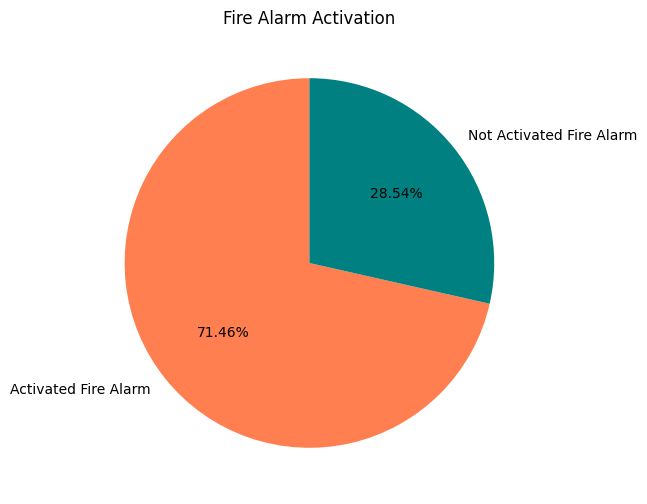

In [6]:
counts = dataset["Fire Alarm"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=["Activated Fire Alarm", "Not Activated Fire Alarm"], autopct='%1.2f%%', startangle=90, colors=["coral", "teal"])
plt.title("Fire Alarm Activation")
plt.show()

# Data Pre-Processing

Innanzittutto rinominiamo la colonna "Unnamed: 0" con il nome "Id", ovvero Id della misurazione rilevata:

In [7]:
dataset = dataset.rename(columns={"Unnamed: 0": "Id"})

Verifichiamo poi la presenza di duplicati:

In [8]:
f"Duplicated values: {dataset.shape[0] - dataset.duplicated().value_counts()[False]}"

'Duplicated values: 0'

### Outliers

Ora vediamo la distribuzione grafica (attraverso istogramma) dei valori per ogni colonna, escluse "Id", "UTC", "Fire Alarm". Attraverso una visualizzazione grafica verifichiamo la presenza di outliers:

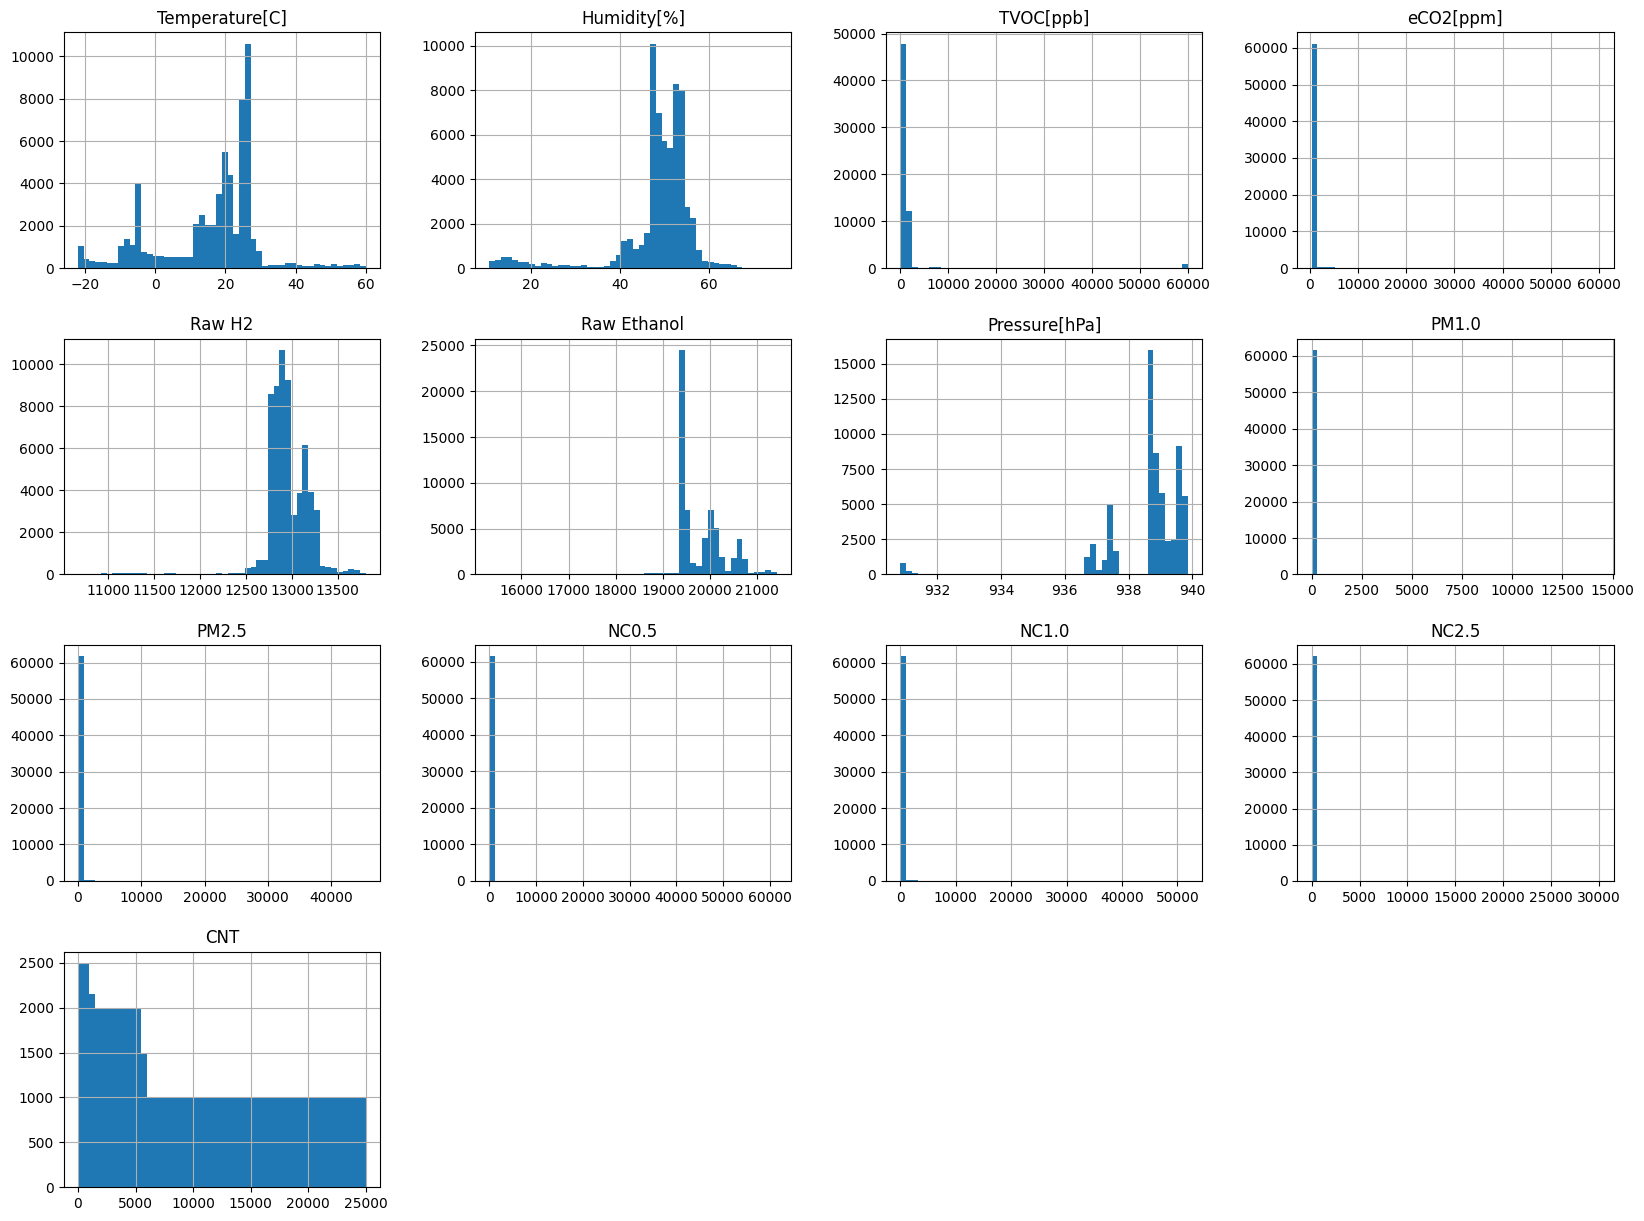

In [9]:
dataset.drop(["Id", "UTC", "Fire Alarm"], axis=1).hist(bins=50, figsize=(20,15))
plt.show()

Notiamo che le possibili colonne con outlier sono: "TVOC[ppb]", "eCO2[ppm]", "Pressure[hPa]","PM1.0", "PM2.5", "NC0.5", "NC1.0", "NC2.5"

In [10]:
outliers_columns = ["TVOC[ppb]", "eCO2[ppm]", "Pressure[hPa]","PM1.0", "PM2.5", "NC0.5", "NC1.0", "NC2.5"]

#### Eliminazione con z-score

In [34]:
from scipy.stats import zscore

def delete_outliers_z(data, column, threshold = 3):
    outliers = data[np.abs(zscore(data[column])) > threshold]
    print(f"{outliers.shape[0]} outliers removed in {column}, {outliers['Fire Alarm'].value_counts()}")
    return data[np.abs(zscore(data[column])) < threshold]

dataset_z = dataset.copy()
for column in outliers_columns:
    dataset_z = delete_outliers_z(dataset_z, column)

1270 outliers removed in TVOC[ppb], Fire Alarm
0    1270
Name: count, dtype: int64
340 outliers removed in eCO2[ppm], Fire Alarm
1    325
0     15
Name: count, dtype: int64
814 outliers removed in Pressure[hPa], Fire Alarm
1    796
0     18
Name: count, dtype: int64
66 outliers removed in PM1.0, Fire Alarm
0    58
1     8
Name: count, dtype: int64
32 outliers removed in PM2.5, Fire Alarm
0    28
1     4
Name: count, dtype: int64
0 outliers removed in NC0.5, Series([], Name: count, dtype: int64)
8 outliers removed in NC1.0, Fire Alarm
0    8
Name: count, dtype: int64
152 outliers removed in NC2.5, Fire Alarm
0    152
Name: count, dtype: int64


In [33]:
dataset_z.describe()

,Id,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
count,59948.000000,5.994800e+04,59948.000000,59948.000000,59948.000000,59948.000000,59948.000000,59948.000000,59948.000000,59948.000000,59948.000000,59948.000000,59948.000000,59948.000000,59948.000000,59948.000000
mean,30365.814506,1.654787e+09,15.458227,49.662166,849.177754,442.853473,12972.757890,19802.832922,938.812908,1.618307,1.681914,11.136751,1.737542,0.039778,10856.051078,0.727697
std,17733.175779,1.049561e+05,13.531924,6.746622,1428.578930,88.065190,179.758888,462.472860,0.782821,0.671423,0.696345,4.624367,0.719143,0.016132,7570.231596,0.445149
min,0.000000,1.654712e+09,-22.010000,11.260000,0.000000,400.000000,12306.000000,18520.000000,936.624000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15069.750000,1.654743e+09,10.751750,47.710000,131.000000,400.000000,12838.000000,19437.000000,938.708000,1.320000,1.370000,9.090000,1.418000,0.033000,3788.000000,0.000000
50%,30139.500000,1.654760e+09,19.990000,50.400000,973.000000,400.000000,12930.000000,19505.000000,938.837000,1.800000,1.870000,12.410000,1.936000,0.044000,10006.500000,1.000000
75%,45126.250000,1.654776e+09,25.070000,53.300000,1182.000000,429.000000,13112.000000,20079.000000,939.467000,2.080000,2.160000,14.280000,2.227000,0.050000,17500.000000,1.000000
max,62629.000000,1.655130e+09,58.260000,75.200000,24861.000000,1014.000000,13803.000000,21410.000000,939.861000,3.620000,3.760000,24.890000,3.881000,0.163000,24993.000000,1.000000


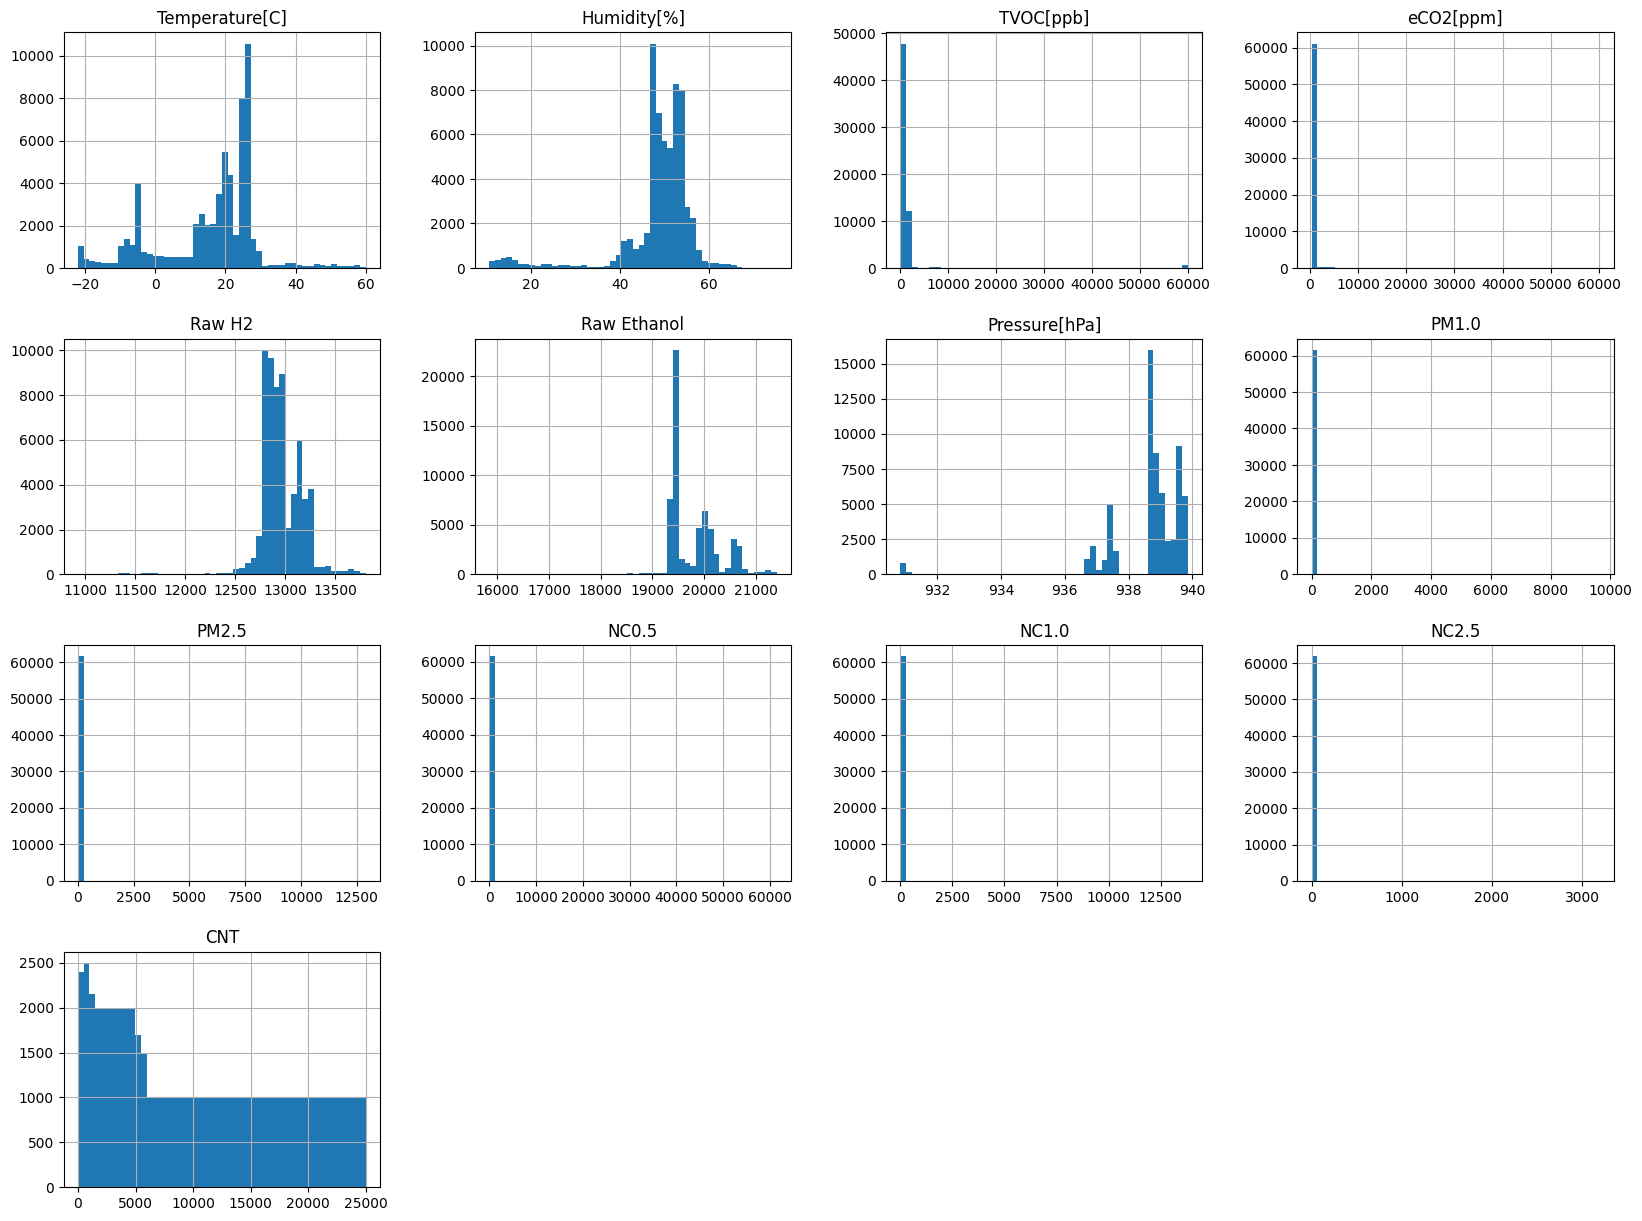

In [13]:
dataset_z.drop(["Id", "UTC", "Fire Alarm"], axis=1).hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
def delete_outliers_q(data, column):
    quarter_1 = data[column].quantile(0.25)
    quarter_3 = data[column].quantile(0.75)
    diff = quarter_3 - quarter_1
    lower_bound = quarter_1 - 1.5 * diff
    upper_bound = quarter_3 + 1.5 * diff
    # print(quarter_1, quarter_3, diff, lower_bound, upper_bound)
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    print(f"{outliers.shape[0]} outliers removed in {column}, {outliers['Fire Alarm'].value_counts()}")
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

dataset_q = dataset.copy()
for column in outliers_columns:
    dataset_q = delete_outliers_q(dataset_q, column)
    print(dataset_q.shape)

2463 outliers removed in TVOC[ppb], Fire Alarm
0    2424
1      39
Name: count, dtype: int64
(60167, 16)
11176 outliers removed in eCO2[ppm], Fire Alarm
1    11128
0       48
Name: count, dtype: int64
(48991, 16)
2175 outliers removed in Pressure[hPa], Fire Alarm
0    2107
1      68
Name: count, dtype: int64
(46816, 16)
12 outliers removed in PM1.0, Fire Alarm
1    12
Name: count, dtype: int64
(46804, 16)
4 outliers removed in PM2.5, Fire Alarm
0    4
Name: count, dtype: int64
(46800, 16)
0 outliers removed in NC0.5, Series([], Name: count, dtype: int64)
(46800, 16)
4 outliers removed in NC1.0, Fire Alarm
0    4
Name: count, dtype: int64
(46796, 16)
260 outliers removed in NC2.5, Fire Alarm
0    260
Name: count, dtype: int64
(46536, 16)


In [15]:
dataset_q.describe()

,Id,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
count,58956.000000,5.895600e+04,58956.000000,58956.000000,58956.000000,58956.000000,58956.000000,58956.000000,58956.00000,58956.000000,58956.000000,58956.000000,58956.000000,58956.000000,58956.000000,58956.000000
mean,31161.310842,1.654790e+09,15.828941,49.027046,1017.500373,482.329585,12968.656863,19803.222318,938.68956,1.654355,1.719156,11.385369,1.775984,0.040455,10935.797917,0.737228
std,17760.652683,1.074669e+05,13.803227,7.874687,2795.324037,817.407413,188.475753,478.981560,1.14620,0.630145,0.653832,4.339272,0.675275,0.014879,7587.930027,0.440143
min,45.000000,1.654712e+09,-22.010000,11.260000,0.000000,400.000000,10939.000000,18393.000000,930.85200,0.000000,0.010000,0.000000,0.014000,0.007000,0.000000,0.000000
25%,15770.750000,1.654744e+09,11.200750,47.590000,137.000000,400.000000,12835.000000,19436.000000,938.70300,1.410000,1.470000,9.740000,1.518000,0.035000,3826.000000,0.000000
50%,31133.500000,1.654762e+09,20.127000,50.120000,1007.000000,400.000000,12925.000000,19493.000000,938.81300,1.810000,1.880000,12.480000,1.946000,0.044000,10250.500000,1.000000
75%,46288.250000,1.654777e+09,25.261250,53.220000,1187.000000,434.000000,13113.000000,20097.000000,939.39200,2.080000,2.160000,14.320000,2.232000,0.050000,17620.000000,1.000000
max,62629.000000,1.655130e+09,58.270000,75.200000,54715.000000,60000.000000,13803.000000,21410.000000,939.85600,3.190000,3.320000,21.970000,3.426000,0.077000,24993.000000,1.000000


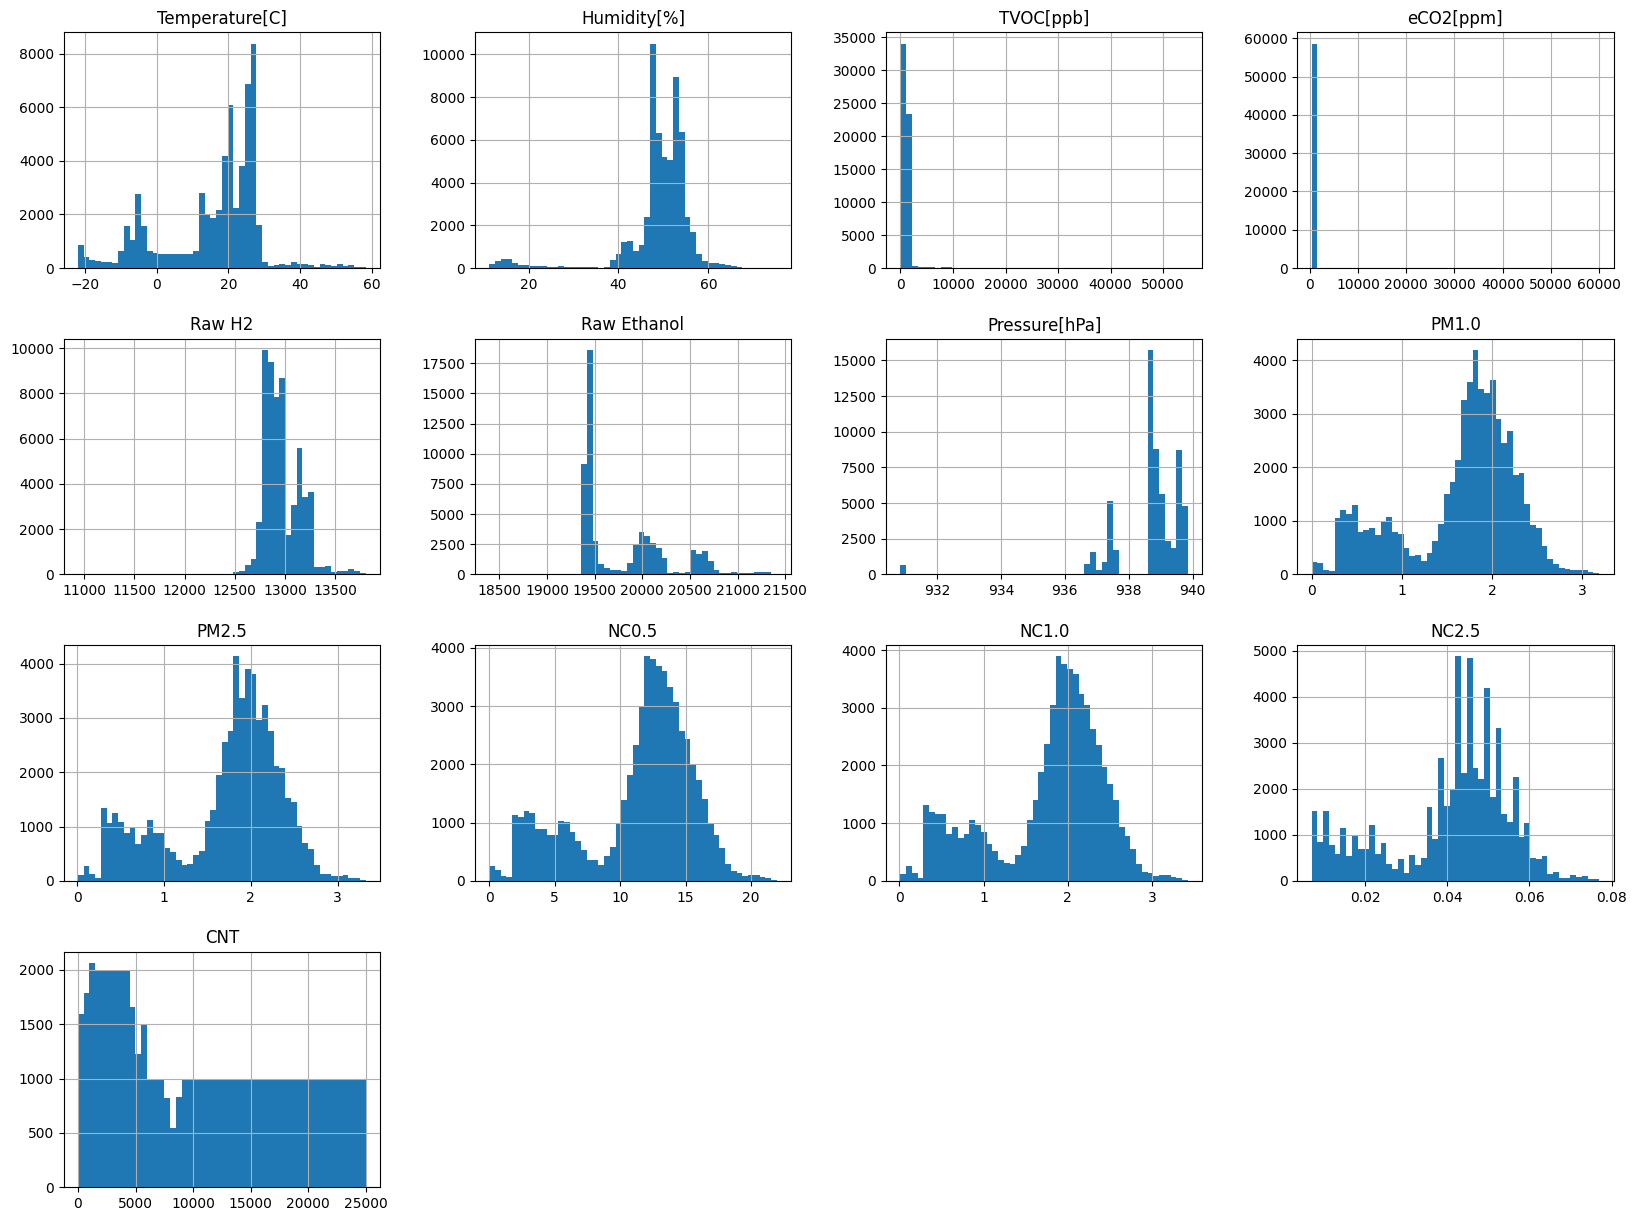

In [16]:
dataset_q.drop(["Id", "UTC", "Fire Alarm"], axis=1).hist(bins=50, figsize=(20,15))
plt.show()